# ARMS Plates Preprocessing Techniques Project


# Introduction: The Idea

The problem that was presented to us for this project is how to best preprocess pictures of aquatic life colonies on plates to serve as training data in a neural network. The overall hope is that preprocessing these images will help achieve better classification of different types of aquatic life on these plates

Our work is to use image processing techiniques learned in class to produce different kinds of images to train the classifier on.

In this project we created and saved images using the following techniques: <br>
Gaussian Blur <br>
Sobel Filter <br>
Canny Filter <br>
Hough Circle Filter <br>
Grey Level Co-Occurence(GLCM) Image Segmentation <br>
Law's Texture Energy Measures <br>

The input images we have to work with are quite large so we opted against using the C code from our assignemnts in favor of Python libraries **OpenCV** and **Skimage** through Google Colab.


# Our Goals



Our goal for this project is to document our findings about the pros and cons of the abuve tested image processing techniques to determine what techniques work for this application and what techniques don't.

in addition to documenting our findings in this report, all resulting images are also saved to a shared drive for future reference or use with a classifier.

>>Below is the drive link to the data folder within the shared drive that contains all input and output images:
https://drive.google.com/drive/folders/1ZnlsWzFA4ub9mNaYqodmjRfTXHaqskeS?usp=sharing

This link will grant vewier permissions only.


As we are not actually training any models ourselves, the measure we use in this project to measure how good or bad the output images are is through a Figure of Merit








# Code



## Setup


In the setup section, all imports and permissions are established to ensure the code has access to all necessary libraries, input images, and file structures for writing output images.

All read and write operations will be done through Google Drive using Google Colab's Drive connection feature.

Input images are read through a zip file 20_ARMS_JPEGS.zip so that all input images are stored in runtime. This cuts runtime in half compared to having to fetch files from the shared drive each time they are needed.

All output files are written to their corresponding folders within the shared drive for future reference

In [ ]:
import cv2 as cv
import PIL
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from scipy.signal import convolve2d

In [ ]:
from skimage.feature import graycomatrix, graycoprops
from skimage.transform import rotate
import skimage.io

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
!pip install -U -q PyDrive
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
fid = drive.ListFile({'q':"title='20_ARMS_JPEGS.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('20_ARMS_JPEGS.zip')

In [ ]:
f.keys()

dict_keys(['id'])

In [ ]:
!unzip 20_ARMS_JPEGS.zip

Archive:  20_ARMS_JPEGS.zip
   creating: 20_ARMS_JPEGS/
  inflating: __MACOSX/._20_ARMS_JPEGS  
  inflating: 20_ARMS_JPEGS/PLATE_HAW-22_2013_A_011.JPG  
  inflating: __MACOSX/20_ARMS_JPEGS/._PLATE_HAW-22_2013_A_011.JPG  
  inflating: 20_ARMS_JPEGS/PLATE_KUR-12_2013_A_079.JPG  
  inflating: __MACOSX/20_ARMS_JPEGS/._PLATE_KUR-12_2013_A_079.JPG  
  inflating: 20_ARMS_JPEGS/PLATE_KIN-05_2015_A_036.JPG  
  inflating: __MACOSX/20_ARMS_JPEGS/._PLATE_KIN-05_2015_A_036.JPG  
  inflating: 20_ARMS_JPEGS/PLATE_ROS-25_2015_C_005.JPG  
  inflating: __MACOSX/20_ARMS_JPEGS/._PLATE_ROS-25_2015_C_005.JPG  
  inflating: 20_ARMS_JPEGS/PLATE_GUA-05_2014_A_007.JPG  
  inflating: __MACOSX/20_ARMS_JPEGS/._PLATE_GUA-05_2014_A_007.JPG  
  inflating: 20_ARMS_JPEGS/PLATE_KUR-12_2013_A_041.JPG  
  inflating: __MACOSX/20_ARMS_JPEGS/._PLATE_KUR-12_2013_A_041.JPG  
  inflating: 20_ARMS_JPEGS/PLATE_KUR-12_2013_A_030.JPG  
  inflating: __MACOSX/20_ARMS_JPEGS/._PLATE_KUR-12_2013_A_030.JPG  
  inflating: 20_ARMS_JPEGS/PL

In [ ]:
# path from zip  <-- cuts runtime in half
PATH = '/content/20_ARMS_JPEGS/'

#path from shared drive
#PATH = '/content/drive/Shareddrives/CS136_termproj/data/20_ARMS_JPEGS/'
filenames = os.listdir(PATH)

for name in filenames:
  print(name)

PLATE_KUR-12_2013_A_003.JPG
PLATE_ROS-25_2015_C_005.JPG
PLATE_GUA-02_2014_A_018.JPG
PLATE_KUR-12_2013_A_059.JPG
PLATE_KUR-12_2013_A_041.JPG
PLATE_GUA-05_2014_A_057.JPG
PLATE_KUR-12_2013_A_030.JPG
PLATE_KIN-05_2015_A_005.JPG
PLATE_JAR-04_2015_B_061.JPG
PLATE_GUA-05_2014_A_007.JPG
PLATE_FFS-32_2013_A_006.JPG
PLATE_JAR-04_2015_A_010.JPG
PLATE_KUR-12_2013_A_079.JPG
PLATE_HAW-22_2013_A_011.JPG
PLATE_JAR-04_2015_B_021.JPG
PLATE_HAW-22_2013_A_041.JPG
PLATE_OFU-04_2015_B_008.JPG
PLATE_JAR-04_2015_A_062.JPG
PLATE_KIN-05_2015_A_036.JPG
PLATE_KIN-05_2015_A_050.JPG


In [ ]:
# set path to shared drive

sharePath = '/content/drive/Shareddrives/CS136_termproj/data/'


## Image Filters

The first image processing techniques we learned is class were edge detectors. By making use of the OpenCV library, the implementation can be condensed to a few lines of code.

In [ ]:
#####IMPORTANT
# Program does not clear drive folder upon each run
# if you are changing the name of the file to be saved to drive
# please manually delete images in associated folder

# program does replace existing images with the same name
# so don't worry about manually clearing folder on each run

### Gaussian Filter

This section tests a simple Gaussian blur filter on each image. While Gaussian filters are generally necessary for edge detection, only applying a Gaussian filter alone isn't very effective for our input images.

The issue is that many of these images are extremely detailed and large with ill-defined edges. As a result, applying a blur with a convolution filter too small does next to nothing to the input image, but applying a blur with a convolution too big loses too much information and detail.


In [ ]:
for i, imgName in enumerate(filenames):
  img = cv.imread(PATH + imgName, cv.IMREAD_GRAYSCALE)
  assert img is not None, "file could not be read, check with os.path.exists()"

  blur = cv.GaussianBlur(img,(5,5),0)


  if not cv.imwrite(sharePath + 'Preprocessing/Gauss/Gauss_' + imgName, blur):
    raise Exception("Could not write to drive")



  if i == 0:  #Example output
    plt.subplot(122),plt.imshow(blur,cmap = 'gray')
    plt.title('Gaussian Blur'), plt.xticks([]), plt.yticks([])
    plt.show()

### Sobel Filter

This section implements a Sobel filter on each image. While Sobel is generally more efficient, it produced rougher edges when compared to the Canny filter.

This is reflected heavily in the resulting images. Because the input images are so detailed, it results in a lot of noise in the output. Almost all output images result in almost a purely white tile.

In [ ]:
for i, imgName in enumerate(filenames):
  img = cv.imread(PATH + imgName, cv.IMREAD_GRAYSCALE)
  assert img is not None, "file could not be read, check with os.path.exists()"

  dx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=5)
  dy = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=5)
  dxabs = cv.convertScaleAbs(dx)
  dyabs = cv.convertScaleAbs(dy)
  mag = cv.addWeighted(dxabs, 0.5, dyabs, 0.5, 0)

  ret,thresh1 = cv.threshold(mag,127,255,cv.THRESH_BINARY)

  #cv.imwrite('/content/Preprocessing/Sobel/Sobel_' + imgName, mag)

  if not cv.imwrite(sharePath + 'Preprocessing/Sobel/Sobel_' + imgName, mag):
    raise Exception("Could not write to drive")

  if not cv.imwrite(sharePath + 'Preprocessing/FM_Sobel/Sobel_' + imgName, thresh1):
    raise Exception("Could not write to drive")

  if i == 0:  #Example output
    plt.subplot(122),plt.imshow(mag,cmap = 'gray')
    plt.title('Sobel Filter'), plt.xticks([]), plt.yticks([])
    plt.show()

### Canny Filter


This section implements a Canny Filter. The Canny Filter takes a bit longer but results in crisper edges in the final image.

The non-maxima supression step gets rid of a lot of the noise that is present in Sobel filter. However, the quality varies from image to image. Some images are just as noisy as Sobel, other images lose too much information.

Overall however, Canny does better than Sobel.




In [ ]:
# super noisy: Canny_PLATE_JAR-04_2015_B_061.JPG

# too much info lost: Canny_PLATE_KUR-12_2013_A_003.JPG

In [ ]:
for i, imgName in enumerate(filenames):
  img = cv.imread(PATH + imgName, cv.IMREAD_GRAYSCALE)
  assert img is not None, "file could not be read, check with os.path.exists()"

  edges = cv.Canny(img,100,200)


  #cv.imwrite('/content/Preprocessing/Canny/Canny_' + imgName, edges)


  if not cv.imwrite(sharePath + 'Preprocessing/Canny/Canny_' + imgName, edges):
    raise Exception("Could not write to drive")

  if i == 0:  #Example output
    plt.subplot(122),plt.imshow(edges,cmap = 'gray')
    plt.title('Canny Image Example'), plt.xticks([]), plt.yticks([])
    plt.show()





### Circle Hough

This section implements the circle hough transform in an attempt to locate the four screwholes present on the plate.

While Hough almost always finds the screwholes, it also includes a lot of noise. We were unable to find a solution around this given the raw input pictures. However, it may be possible if the input pictures are cropped down to just the plate and only the sections of the image that contain screwholes are filtered.

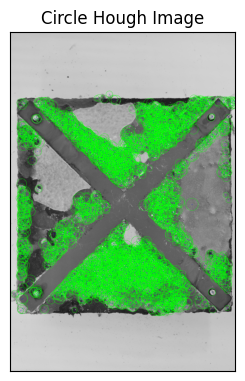

In [ ]:
for i, imgName in enumerate(filenames):
  img = cv.imread(PATH + imgName, cv.IMREAD_GRAYSCALE)
  assert img is not None, "file could not be read, check with os.path.exists()"

  img = cv.medianBlur(img,5)
  cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)
  circles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1,20,
                            param1=50,param2=30,minRadius=30,maxRadius=80)
  circles = np.uint16(np.around(circles))
  blank_image = np.zeros((img.shape[0],img.shape[1],1), np.uint8)
  for j in circles[0,:]:
    # draw the outer circle
    cv.circle(cimg,(j[0],j[1]),j[2],(0,255,0),2)
    cv.circle(blank_image,(j[0],j[1]),j[2],(255,255,255),2)
    # draw the center of the circle
    cv.circle(cimg,(j[0],j[1]),2,(0,0,255),3)
    cv.circle(blank_image,(j[0],j[1]),j[2],(255,255,255),3)

  #cv.imwrite('/content/Preprocessing/Hough/Hough_' + imgName, cimg)

  if not cv.imwrite(sharePath + 'Preprocessing/Hough/Hough_' + imgName, cimg):
    raise Exception("Could not write to drive")

  if not cv.imwrite(sharePath + 'Preprocessing/FM_Hough/Hough_' + imgName, blank_image):
    raise Exception("Could not write to drive")


  if i == 0:  #Example output
    plt.subplot(122),plt.imshow(cimg ,cmap = 'gray')
    plt.title('Circle Hough Image'), plt.xticks([]), plt.yticks([])
    plt.show()

## Image Segmentation

Image Segmentation is the second category of image processing techiques we learned. The two techniques implemented here are Grey Level Co-Occurence Matrx (GLCM) and Law's Texture Energy Measures.

The goal for this section is to achieve a good segentation of the image in a way that isolates and labels pixels containing species of interest.

### Grey Level Co-Occurence Matrix (GLCM)

the GLCM implementation below was testing on this specific input image that contains ample amounts of both Orange sponge and CCA. The goal was to test if GLCM is able to accurately distinguish between the two species.

Judging by the corellation/dissimilarity graph, there does seem to be a fairly clear split between the two, the issue however is that the implementation required manual selection of patches of Orange sponge and CCA rendering it pointless for classification.

That being said, the upside that we learned from this is that GLCM seems to be decent at seperating Orange Sponge and CCA, an issue that will crop up in the Law's Texture Energy section.

<class 'numpy.ndarray'>
(2848, 4288)
83


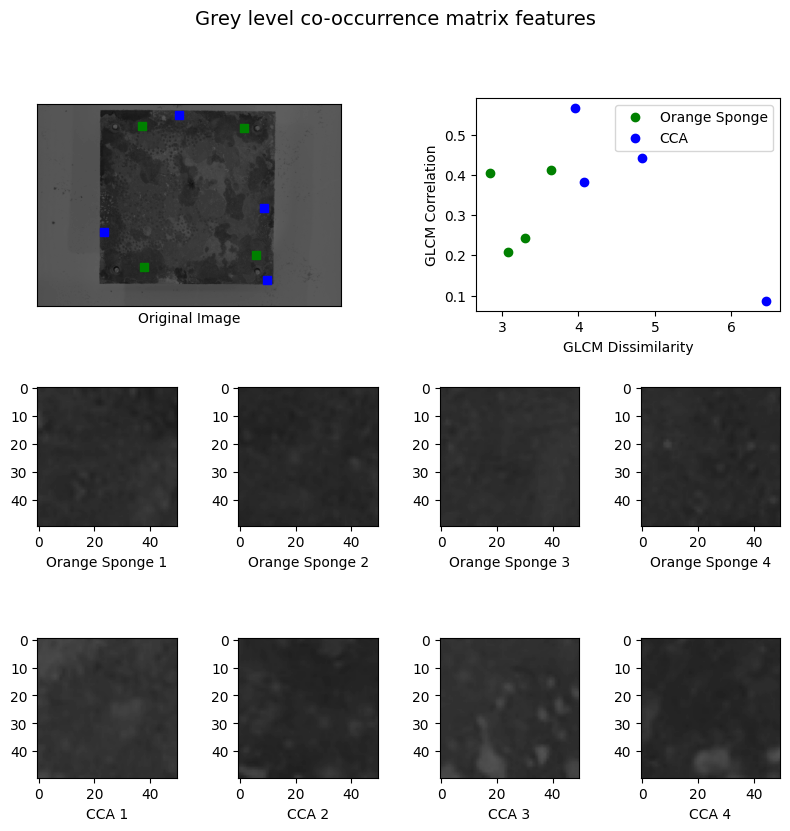

In [ ]:
# GLCM using scikit-image  --- currently testing for orange sponges & CCA on image: PLATE_KIN-05_2015_A_036.JPG
# reference: https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_glcm.html


PATCH_SIZE = 50

# must read as gray for numpy 2d array
image = skimage.io.imread('/content/20_ARMS_JPEGS/PLATE_KIN-05_2015_A_036.JPG', as_gray=True)


print(type(image))
print(image.shape)

# cast from float numpy array to int array
for iy, ix in np.ndindex(image.shape):
  image[iy, ix] = image[iy, ix]*100
image = image.astype(np.int32)
print(image[1, 1])

# select patches of orange sponge
# [(1451, 291), (1474, 2280), (3062, 2115), (2887, 324)]
orange_sponge_loc = [(291, 1451), (2280, 1474), (2115, 3062), (324, 2887)]
orange_sponge_patches = []
for loc in orange_sponge_loc:
  orange_sponge_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                                     loc[1]:loc[1] + PATCH_SIZE])


# select patches of CCA
# [(1979, 136), (920, 1791), (3172, 1451), (3207, 2462)]
CCA_loc = [(136, 1979), (1791, 920), (1451, 3172), (2462, 3207)]
CCA_patches = []
for loc in CCA_loc:
  CCA_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                           loc[1]:loc[1] + PATCH_SIZE])



# compute some GLCM properties each patch
xs = []
ys = []
for patch in (orange_sponge_patches + CCA_patches):
    glcm = graycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    xs.append(graycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(graycoprops(glcm, 'correlation')[0, 0])

# create the figure
fig = plt.figure(figsize=(8, 8))


# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(image, cmap=plt.cm.gray,
          vmin=0, vmax=255)
for (y, x) in orange_sponge_loc:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for (y, x) in CCA_loc:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(xs[:len(orange_sponge_loc)], ys[:len(orange_sponge_patches)], 'go',
        label='Orange Sponge')
ax.plot(xs[len(CCA_loc):], ys[len(CCA_patches):], 'bo',
        label='CCA')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

# display the image patches
for i, patch in enumerate(orange_sponge_patches):
    ax = fig.add_subplot(3, len(orange_sponge_patches), len(orange_sponge_patches)*1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel(f"Orange Sponge {i + 1}")

for i, patch in enumerate(CCA_patches):
    ax = fig.add_subplot(3, len(CCA_patches), len(CCA_patches)*2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel(f"CCA {i + 1}")


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

#----------------------------------------------------------------------------------


**GLCM without manual input.**

Below is a GLCM implementation that does not require manual selection of texture location. The full implementation was pulled off this Github: <br>
https://github.com/adfoucart/image-processing-notebooks/blob/main/V29%20-%20Texture%20segmentation.ipynb <br>

After testing it on one example image with a low degree of detail, it took super long to complete. All it really did was seperate the plate from the background. Even then it wasn't really a clean split. It was after this that we decided to scrap the idea of using GLCM for this project as trying to go for a higher level of detail may take way too long.

However, this section is left in as a proof of concept about a method that _might_ work if a lot more time is put in testing different thresholds. But for the purpose of this project, it just takes way to long.



<class 'numpy.ndarray'>
(2848, 4288)


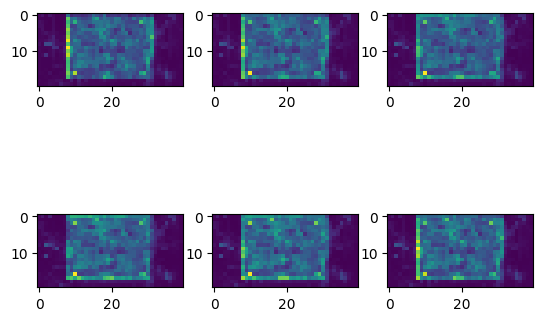

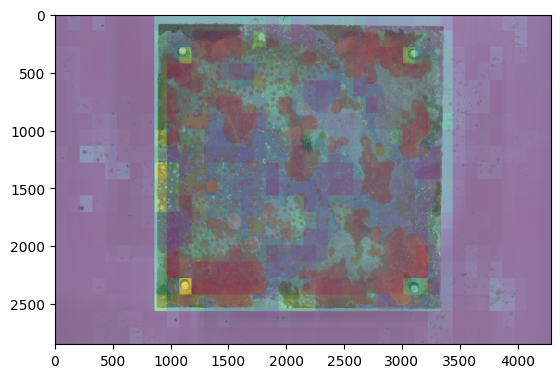

-0.09271512364339562


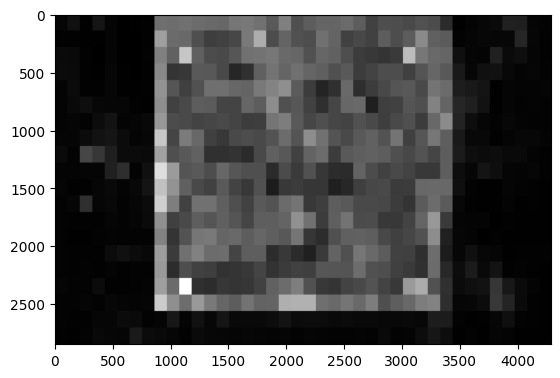

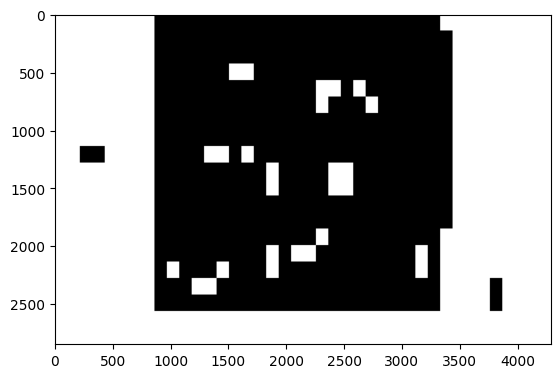

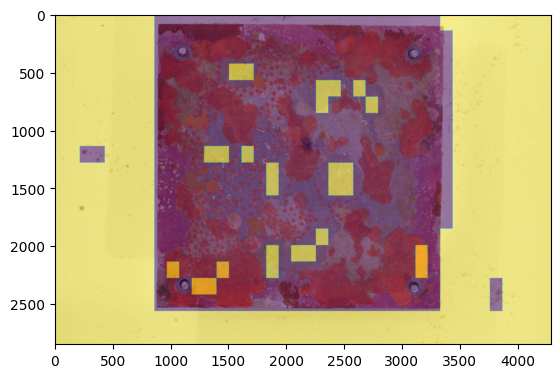

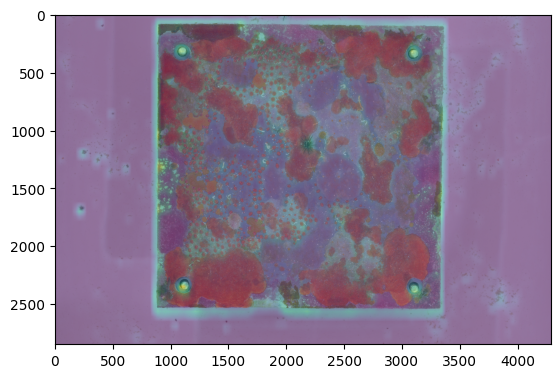

In [ ]:
# something pulled off github, not fully sure about it yet
# https://github.com/adfoucart/image-processing-notebooks/blob/main/V29%20-%20Texture%20segmentation.ipynb
# this block takes a while to run

from skimage.color import rgb2gray

im = skimage.io.imread('/content/20_ARMS_JPEGS/PLATE_KIN-05_2015_A_036.JPG')

imgray = (rgb2gray(imageColor)*255).astype('uint8');
print(type(imgray))
print(imgray.shape)

def get_descriptors(region, angles, displacements, props):
    glcm = graycomatrix(region, displacements, angles, 256, normed=True, symmetric=True)
    descriptors = []
    for prop in props:
        descriptors += [graycoprops(glcm, prop)]
    return np.array(descriptors).flatten()

angles = [0,np.pi/6,np.pi/3,np.pi/2,2*np.pi/3,5*np.pi/6]
displacements = [20]
props = ['dissimilarity']

n_cells_x = 40
n_cells_y = 20
size_x = im.shape[1]//n_cells_x
size_y = im.shape[0]//n_cells_y

descriptors = np.zeros((n_cells_y,n_cells_x,len(angles)*len(displacements)*len(props)))
for y in range(n_cells_y):
    for x in range(n_cells_x):
        descriptors[y,x] = get_descriptors(imgray[y*size_y:(y+1)*size_y,x*size_x:(x+1)*size_x],angles,displacements,props)

ndescriptors = (descriptors-descriptors.mean(axis=(0,1)))/descriptors.std(axis=(0,1))


plt.figure()
for i in range(ndescriptors.shape[2]):
    plt.subplot(int(ndescriptors.shape[2]/3),3,i+1)
    plt.imshow(ndescriptors[:,:,i])
plt.show()


from skimage.transform import resize

overlay = resize(ndescriptors.sum(axis=2), im.shape[:2], order=0)

plt.figure()
plt.imshow(im)
plt.imshow(overlay,alpha=0.5)
plt.show()

from skimage.filters import threshold_otsu

t = threshold_otsu(overlay)
print(t)

plt.figure()
plt.imshow(overlay, cmap=plt.cm.gray)
plt.figure()
plt.imshow(overlay<t, cmap=plt.cm.gray)
plt.show()

mask = overlay<t

plt.figure()
plt.imshow(im)
plt.imshow(mask,alpha=0.5)
plt.show()

size_x = 64
size_y = 84
step_x = 32
step_y = 42

ys = np.arange(0,im.shape[0]-size_y+1,step_y)
xs = np.arange(0,im.shape[1]-size_x+1,step_x)

descriptors = np.zeros((len(ys),len(xs),len(angles)*len(displacements)*len(props)))
for idy,y in enumerate(ys):
    for idx,x in enumerate(xs):
        descriptors[idy,idx] = get_descriptors(imgray[y:y+size_y,x:x+size_x],angles,displacements,props)
overlay = resize(descriptors.sum(axis=2), im.shape[:2], order=1, mode='constant')

plt.figure()
plt.imshow(im)
plt.imshow(overlay,alpha=0.5)
plt.show()

t = threshold_otsu(overlay)
mask = resize(overlay<t, im.shape[:2], order=0)

plt.figure()
plt.imshow(im)
plt.imshow(mask,alpha=0.5)
plt.show()

### Law's Texture Energy Measures

This section implements Law's Texture Energy Measures. We were unable to find a library that fit our purposes so we had to implement it from scratch.

The implementation itself isn't particularaly complicated but since it requires so many convolutions, this method is quite slow.

the output quality of the segmentation depends on the thresholds set for each color. The method used to determine these thresholds involved manually plotting points on species of interest and noting the energy at that point.

some of these energies are noted in the commented block below created during testing.

The Pros for this image segmentations technique is that depending on the set thresholds, it does a great job separating the background from the plate, and the aquatic life from the empty areas of the plate.
We found that it also does a great job of specifically isolating White Sponge as long as the background is ignored.

the cons of this techinque is that there is a lot of overlap between the energies of Orange Sponge and CCA leading to a lot of misclassification regardless of the threshold. Also, with the current threshold set to primarily detect and isolate White Sponge works by not coloring anything over 2000 energy leaving pixels containing White Sponge black. As a consequence however, in terms of raw data, the background is also classified as White Sponge which could lead to error if these images are fed to a Neural Network.

The error above can be fixed by just cropping the images to only the plate but that may require manual time and energy.

Overall, we found that this technique could be useful in 3 ways: <br>
1. detecting how much of the plate is covered with life
2. isolating Orange Sponge AND CCA in the whole image (due to overlap in energies)
3. Isolationg just White Sponge just on the plate

In [ ]:
# WITHOUT SUMMED NEIGHBORS
# energy ranges --- PLATE_KIN-05_2015_A_036.JPG
# orange sponge: 715.96, 1860.4, 1001.52, 2771.04, 1142.56, 1446.76, 1022.36
# CCA: 1313.56, 1351.08, 1043.76
# has a hard time differentiating between bright orange sponge and CCA  only darker (older?) orange is distinct
# thresholds = [1200, 1400, 2300, 2500]

# energy ranges --- PLATE_JAR-04_2015_A_062.JPG
# Has a massive white sponge: ~2000+
# thresholds = [1200, 1400, 2000, 2001]
# really white sponge seems to always be over 2000
# kinda orangey white sponge? starts ~1800-1900

# decent at isolating white sponge
# would do even better if image was trimmed to only contain the plate

# there is some misclassification with some of the orangey white sponge? (not sure if it's actually white sponge)
# ^ see PLATE_GUA-05_2014_A_057.JPG or PLATE_GUA-05_2014_A_007.JPG
# but this should be fixable by playing more with the thresholds

to experiement with the thresholds, replace the values in the list assigned to the variable 'thresholds'

for reference:

these thresholds were found to be good for isolating Orange Sponge and CCA with the least overlap:<br>
thresholds = [1200, 1400, 2300, 2500]

these thesholds were good at isolating White Sponge: <br>
thresholds = [1200, 1400, 2000, 2001]

^ All the White Sponge thresholds really do is not color anything above 2000 energy. If this techinque is deemed useful for White Sponge, the code can be optimized to just require 1 threshold. This way anything below 2000 is ignored and anything above 2000 is White Sponge (as long as they are within the bounds of the plate)

In [ ]:
# s

#img = cv.imread('/content/20_ARMS_JPEGS/PLATE_JAR-04_2015_B_021.JPG', cv.IMREAD_GRAYSCALE)
#cv.imread() reads in matrix as (y,x)


# Law's takes a while to computer, 10 mins for 20 given images on colab

for i, imgName in enumerate(filenames):
  img = cv.imread(PATH + imgName, cv.IMREAD_GRAYSCALE)
  assert img is not None, "file could not be read, check with os.path.exists()"

  img_array = np.array(img, dtype=np.float32)

  all_masks = []
  law_filters = [[1.0, 4.0, 6.0, 4.0, 1.0], [-1.0, -2.0, 0.0, 2.0, 1.0], [-1.0, 0.0, 2.0, 0.0, -1.0], [1.0, -4.0, 6.0, -4.0, 1.0], [-1.0, 2.0, 0.0, -2.0, 1.0]]

  for i in range(5):
    for j in range(5):
      tempVec = np.array(law_filters[i], dtype=np.float32)
      tempVec2 = np.array(law_filters[j], dtype=np.float32)
      newMask = np.outer(tempVec, tempVec2)
      all_masks.append(newMask)


  summed_image = np.zeros_like(img_array, dtype=np.float32)

  for mask in all_masks:
    result = convolve2d(img_array, mask, mode='same', boundary='symm')

    #NOT SURE IF NEEDED. Sums the surrounding 8 neighbors for each pixel to "Find the Law's Texture Energy to capture local features"

    #neighborhood_size = 1
    #neighborhood_filter = np.ones((2 * neighborhood_size + 1, 2 * neighborhood_size + 1), dtype=np.float32)
    #result = convolve2d(result, neighborhood_filter, mode='same', boundary='symm')
    summed_image += result

  #Normalization, doesn't mean anything tbh
  summed_image /= 25

  energy = np.sum(np.square(summed_image))

  segmented_mask = np.zeros_like(img)

  # SAMPLE THRESHOLDS WITH NEIGHBORS SUMMED
  #thresholds = [5000, 10000, 15000, 20000]

  # SAMPLE THRESHOLDS WITHOUT NEIGHBORS SUMMED
  thresholds = [1200, 1400, 2000, 2001]

  for i in range(len(thresholds) + 1):
      if i == 0:
          mask = summed_image <= thresholds[i]
      elif i == len(thresholds):
          mask = summed_image > thresholds[-1]
      else:
          mask = (summed_image > thresholds[i-1]) & (summed_image <= thresholds[i])

      segmented_mask[mask] = i + 1
  #print(summed_image)

  colored_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
  colored_image[np.where(segmented_mask == 1)] = [255, 0, 0]  # Red
  colored_image[np.where(segmented_mask == 2)] = [0, 0, 255]  # Blue
  colored_image[np.where(segmented_mask == 3)] = [0, 255, 0]  # Green
  colored_image[np.where(segmented_mask == 4)] = [255, 165, 0]  # Orange

  #plt.subplot(131), plt.imshow(img_array, cmap='gray'), plt.title('Original Image')
  #plt.subplot(133), plt.imshow(colored_image), plt.title('Color-coded Segmentation')
  #plt.show()

  #print("done")

  if not cv.imwrite(sharePath + 'Preprocessing/Laws/Laws_' + imgName, colored_image):
    raise Exception("Could not write to drive")




[[1984.04 1976.92 1978.   ... 2048.56 2048.56 2038.48]
 [1977.24 1975.36 1976.04 ... 2048.56 2048.56 2038.48]
 [1978.96 1982.64 1975.48 ... 2049.68 2049.8  2046.32]
 ...
 [2131.92 2131.84 2132.48 ... 2026.88 2026.32 2036.52]
 [2131.56 2130.72 2133.04 ... 2026.88 2034.16 2035.96]
 [2128.8  2121.96 2122.6  ... 2026.88 2034.16 2035.96]]
[[2600.96 2600.96 2600.96 ... 2579.24 2526.24 2444.76]
 [2600.96 2600.96 2600.96 ... 2595.64 2560.56 2493.72]
 [2600.96 2600.96 2600.96 ... 2600.2  2574.64 2532.28]
 ...
 [2335.92 2335.08 2334.   ... 2611.2  2611.2  2611.2 ]
 [2327.08 2327.12 2327.04 ... 2611.2  2611.2  2611.2 ]
 [2343.76 2337.08 2328.72 ... 2611.2  2611.2  2611.2 ]]
[[2611.2 2611.2 2611.2 ... 2611.2 2611.2 2611.2]
 [2611.2 2611.2 2611.2 ... 2611.2 2611.2 2611.2]
 [2611.2 2611.2 2611.2 ... 2611.2 2611.2 2611.2]
 ...
 [2611.2 2611.2 2611.2 ... 2611.2 2611.2 2611.2]
 [2611.2 2611.2 2611.2 ... 2611.2 2611.2 2611.2]
 [2611.2 2611.2 2611.2 ... 2611.2 2611.2 2611.2]]
[[2611.2  2611.2  2611.2  ..

This block below just gives a side by side comparison of one of the segmented images obtained from above.

summed_image: (2136, 3216)
img_array: (2136, 3216)
2611.2


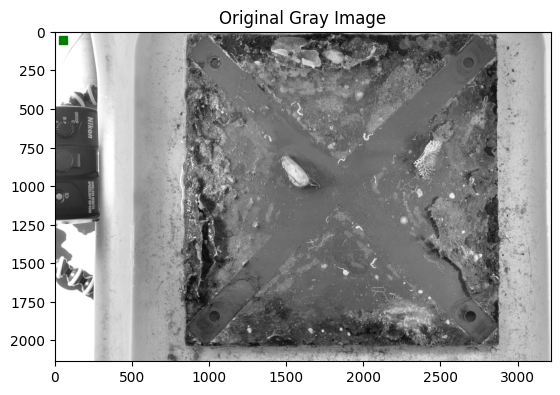

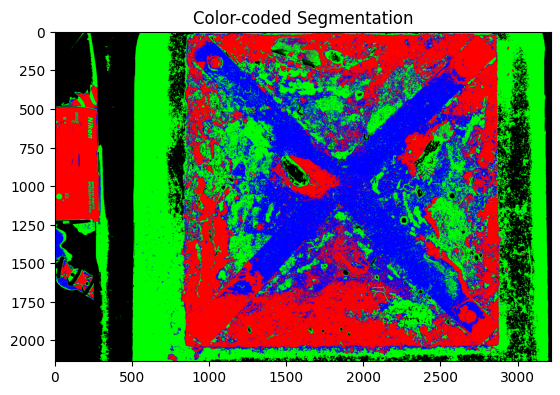

Overall Image Energy: 17518174000000.0


In [ ]:

print(f'summed_image: {summed_image.shape}')

#img_array = cv.rotate(img_array, cv.ROTATE_90_COUNTERCLOCKWISE)
print(f'img_array: {img_array.shape}')

# testing energies here
x = 50
y = 50
print(summed_image[y, x])


plt.figure()
plt.imshow(img_array, cmap='gray')
plt.plot(x, y, 'gs')
plt.title('Original Gray Image')
plt.show()

plt.figure()
plt.imshow(colored_image)
plt.title('Color-coded Segmentation')
plt.show()

print("Overall Image Energy:", energy)

## Figure of Merit

The figure of merit was hard to calculate, as we don't know the true positions for each screw. Therefore, I did two ways as a guestimate in order to find some degree of ranking system. First, I visualized examined the number of screws in each image, then the output of each edge detection algorithm to find a percentage of screws detected. Unfortunately, this doesn't penalize partial detection like Sobel so often does.

I then traced the outline of each screw in GIMP, then overlayed each edge detection algorithm onto the screw outline. I calculated the percentage of pixels that they were both white, as a % of the screws pixels that were successfully detected. However, without a way to penalize wrong pixels, this isn't a reliable way to judge each algorithm. Visually, I believe that canny is the best since the non-maxima suppression is able to remove a lot of unncessary noise



In [ ]:
#Will determine the figure of Merit, Modified as a percentage of circles detected.
#Screws:  1 | Canny -     0      Sobel -    1     Hough -   0    PLATE_FFS-32_2013_A_006
#Screws:  4 | Canny -     4      Sobel -    4     Hough -   4    PLATE_GUA-02_2014_A_018
#Screws:  4 | Canny -     4      Sobel -    4     Hough -   4    PLATE_GUA-05_2014_A_007
#Screws:  4 | Canny -     4      Sobel -    4     Hough -   4    PLATE_GUA-05_2014_A_057
#Screws:  4 | Canny -     4      Sobel -    4     Hough -   4    PLATE_HAW-22_2013_A_011
#Screws:  4 | Canny -     4      Sobel -    4     Hough -   4    PLATE_HAW-22_2013_A_041
#Screws:  4 | Canny -     4      Sobel -    4     Hough -   4    PLATE_JAR-04_2015_A_010
#Screws:  4 | Canny -     4      Sobel -    4     Hough -   4    PLATE_JAR-04_2015_A_062
#Screws:  4 | Canny -     4      Sobel -    4     Hough -   4    PLATE_JAR-04_2015_B_021
#Screws:  4 | Canny -     4      Sobel -    4     Hough -   4    PLATE_JAR-04_2015_B_061
#Screws:  4 | Canny -     4      Sobel -    4     Hough -   4    PLATE_KIN-05_2015_A_005
#Screws:  4 | Canny -     4      Sobel -    4     Hough -   4    PLATE_KIN-05_2015_A_036
#Screws:  4 | Canny -     4      Sobel -    4     Hough -   4    PLATE_KIN-05_2015_A_050
#Screws:  4 | Canny -     0      Sobel -    4     Hough -   4    PLATE_KUR-12_2013_A_003
#Screws:  1 | Canny -     0      Sobel -    1     Hough -   1    PLATE_KUR-12_2013_A_030
#Screws:  1 | Canny -     0      Sobel -    1     Hough -   1    PLATE_KUR-12_2013_A_041
#Screws:  1 | Canny -     0      Sobel -    1     Hough -   0    PLATE_KUR-12_2013_A_059
#Screws:  1 | Canny -     0      Sobel -    1     Hough -   1    PLATE_KUR-12_2013_A_079
#Screws:  4 | Canny -     4      Sobel -    4     Hough -   4    PLATE_OFU-04_2015_B_008
#Screws:  4 | Canny -     4      Sobel -    4     Hough -   4    PLATE_ROS-25_2015_C_005
#Total -  65.             56.               65.             63.

In [ ]:
#Comments, although Canny has some problems detecting the screws, the nonmaxima edge supression makes some
#boundaries look somewhat viable.

#Sobel is okay, but incredibly noisy, and Hough faces the same problems.

#Overall seems like Canny is the winner, by occam's razor as it reduces noise and gives the image clarity

In [ ]:
totalWhitePixels, totalCanny, totalSobel, totalHough = 0, 0, 0, 0

for i, imgName in enumerate(filenames):
  img = PIL.Image.open(sharePath + 'Preprocessing/FM_Manual/' + imgName)
  pix = img.load()
  width = img.size[0]
  height = img.size[1]

  img2 = PIL.Image.open(sharePath + 'Preprocessing/Canny/Canny_' + imgName)
  img3 = PIL.Image.open(sharePath + 'Preprocessing/FM_Sobel/Sobel_' + imgName)
  img4 = PIL.Image.open(sharePath + 'Preprocessing/FM_Hough/Hough_' + imgName)

  canny = img2.load()
  sobel = img3.load()
  hough = img4.load()

  currentTotal = 0
  currentCanny = 0
  currentSobel = 0
  currentHough = 0

  for h in range(height):
    for w in range(width):
      if pix[w, h] == (255, 255, 255):
        currentTotal += 1
        if canny[w, h] >= 250:
          currentCanny += 1
        if sobel[w, h] >= 250:
          currentSobel += 1
        if hough[w, h] >= 250:
          currentHough += 1

  print(f"For image {imgName} Canny acc is {round(currentCanny / currentTotal, 2)}, Sobel acc is {round(currentSobel / currentTotal, 2)}, and Hough acc is {round(currentHough / currentTotal, 2)}.")

  totalWhitePixels += currentTotal
  totalCanny += currentCanny
  totalSobel += currentSobel
  totalHough += currentHough

print(f"Final cumulative acc: Canny acc is {round(totalCanny / totalWhitePixels, 2)}, Sobel acc is {round(totalSobel / totalWhitePixels, 2)}, and Hough acc is {round(totalHough / totalWhitePixels, 2)}.")


For image PLATE_GUA-05_2014_A_007.JPG Canny acc is 0.32, Sobel acc is 0.99, and Hough acc is 0.4.
For image PLATE_KIN-05_2015_A_050.JPG Canny acc is 0.38, Sobel acc is 0.99, and Hough acc is 0.55.
For image PLATE_JAR-04_2015_B_061.JPG Canny acc is 0.31, Sobel acc is 0.96, and Hough acc is 0.94.
For image PLATE_GUA-02_2014_A_018.JPG Canny acc is 0.23, Sobel acc is 0.96, and Hough acc is 0.58.
For image PLATE_OFU-04_2015_B_008.JPG Canny acc is 0.38, Sobel acc is 0.99, and Hough acc is 0.39.
For image PLATE_HAW-22_2013_A_011.JPG Canny acc is 0.29, Sobel acc is 0.94, and Hough acc is 0.82.
For image PLATE_FFS-32_2013_A_006.JPG Canny acc is 0.0, Sobel acc is 0.77, and Hough acc is 0.0.
For image PLATE_JAR-04_2015_A_062.JPG Canny acc is 0.02, Sobel acc is 0.54, and Hough acc is 0.31.
For image PLATE_JAR-04_2015_B_021.JPG Canny acc is 0.21, Sobel acc is 0.95, and Hough acc is 0.41.
For image PLATE_JAR-04_2015_A_010.JPG Canny acc is 0.04, Sobel acc is 0.24, and Hough acc is 0.25.
For image PLA

In [ ]:
#Unfortunately, it seems like Canny is still the lowest for this version of FM score.
#Without a way to penalize wrong boundaries, Sobel will always win unless a high threshold is set
#Since a white image is always 100% and a black image is always 0% accuracy.

#However, it is still of my opinion that Canny is better since nonMaxima suppression clears out a bunch of noise.

## Color Segmentation

All image segmentation techniques up till now relied on grayscale images so we figured we'd try something that relied on color instead.

This color segmentation technique isolates pixels within a certain color range in the HSV color space by creating color masks and overlaying it onto the input image.

### imports

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from matplotlib.colors import hsv_to_rgb

### HSV 3D Color Space

THE BELOW CODE SEGMENT IS PURELY FOR DEMONSTRATION AND TAKES A LONG TIME TO RUN. ~5mins

The way OpenCV represents HSV is different
from how online converters represent HSV.

The three values (Hue, Saturation, Value) are represented in the ranges (0-180, 0-255, 0-255) so we were unable to just plug in HSV converted values based on online pixel color pickers like this site: <br>
https://imagecolorpicker.com/en <br>
and online RGB to HSV converters like this site: <br>
https://toolstud.io/color/rgb.php <br>


Therefore, this section maps out all color pixels in OpenCV's HSV representation space.

It was through this graph that the HSV values for the masks were obtained.

source: https://realpython.com/python-opencv-color-spaces/



In [ ]:
## HSV space

#img = cs.imread(PATH + )
img = cv.imread('/content/20_ARMS_JPEGS/PLATE_KIN-05_2015_A_036.JPG')
assert img is not None, "file could not be read, check with os.path.exists()"



img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.show()

# OpenCV reads images in BGR so image needs to be converted to RGB
img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)


r, g, b = cv.split(img_rgb)
pixel_colors = img_rgb.reshape((np.shape(img_rgb)[0]*np.shape(img_rgb)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

h, s, v = cv.split(img_hsv)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()



### Orange Sponge

After much trial and error, the final thresholds we settled on for isolating Orange Sponge are as below.



Values for Orange Sponge Mask

In [ ]:

# Orange Sponge Mask
# OpenCV HSV values
orangesponge_light = np.array([25, 255, 255])
orangesponge_dark = np.array([0, 150, 150])


Using this method, we were able to isolate Orange Sponge from the rest of the image with a surprising degree of accuracy as seen in the example output below.

Display example output

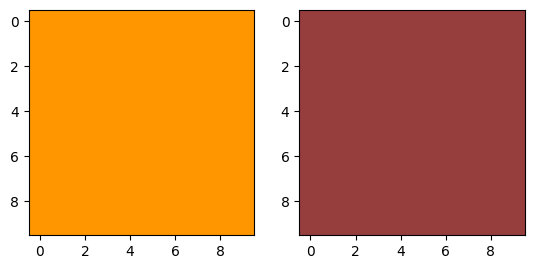

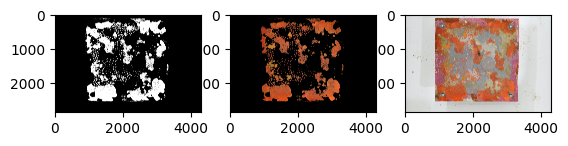

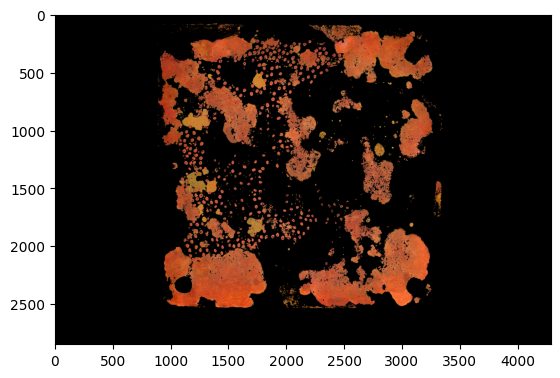

In [ ]:
#test display color range orange

lo_square = np.full((10, 10, 3), orangesponge_light, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), orangesponge_dark, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(lo_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(do_square))
plt.show()



# for example output
img = cv.imread('/content/20_ARMS_JPEGS/PLATE_KIN-05_2015_A_036.JPG')
assert img is not None, "file could not be read, check with os.path.exists()"

# RGB version
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# OpenCV reads images in BGR so image needs to be converted to RGB
img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

orange_mask = cv.inRange(img_hsv, orangesponge_dark, orangesponge_light)
result_img = cv.bitwise_and(img_rgb, img_rgb, mask=orange_mask)


plt.subplot(1,3,1)
plt.imshow(orange_mask, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(result_img)
plt.subplot(1, 3, 3)
plt.imshow(img_rgb)
plt.show()

plt.plot()
plt.imshow(result_img)
plt.show()

Generate actual outputs to write to drive

In [ ]:

# for actual output files
for i, imgName in enumerate(filenames):
  img = cv.imread(PATH + imgName)
  assert img is not None, "file could not be read, check with os.path.exists()"

  # RGB version
  img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

  # OpenCV reads images in BGR so image needs to be converted to RGB
  img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

  orange_mask = cv.inRange(img_hsv, orangesponge_dark, orangesponge_light)
  result_img = cv.bitwise_and(img_rgb, img_rgb, mask=orange_mask)

  # convert RGB back to BGR so output image looks normal
  result_img = cv.cvtColor(result_img, cv.COLOR_RGB2BGR)

  if not cv.imwrite(sharePath + 'Preprocessing/ColorSeg_Orange/ColorSeg_Orange_' + imgName, result_img):
    raise Exception("Could not write to drive")






### CCA

Values for CCA mask

In [ ]:
# CCA
# in OpenCV HSV
CCA_light = np.array([180, 200, 200])
CCA_dark = np.array([120, 50, 100])


Similar to Orange Sponge, CCA also has a distinct color range making this method effective for isolating CCA as well.

Example output

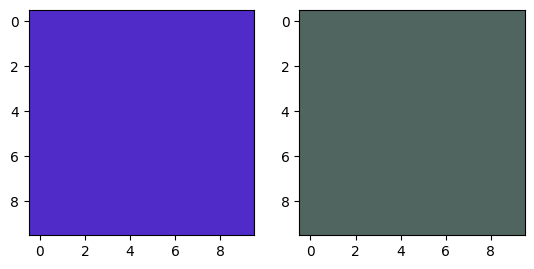

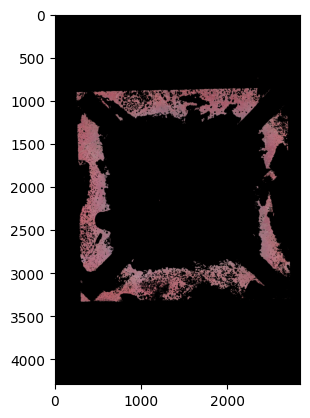

In [ ]:
#test display color range orange

lo_square = np.full((10, 10, 3), CCA_light, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), CCA_dark, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(lo_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(do_square))
plt.show()


img = cv.imread('/content/20_ARMS_JPEGS/PLATE_KIN-05_2015_A_005.JPG')
assert img is not None, "file could not be read, check with os.path.exists()"

img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# OpenCV reads images in BGR so image needs to be converted to RGB
img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)


CCA_mask = cv.inRange(img_hsv, CCA_dark, CCA_light)

result_img = cv.bitwise_and(img_rgb, img_rgb, mask=CCA_mask)


plt.subplot(1,3,1)
plt.imshow(CCA_mask, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(result_img)
plt.subplot(1, 3, 3)
plt.imshow(img_rgb)
plt.show()

plt.plot()
plt.imshow(result_img)
plt.show()

Generating actual outputs to write to drive

In [ ]:
# for actual output files
for i, imgName in enumerate(filenames):
  img = cv.imread(PATH + imgName)
  assert img is not None, "file could not be read, check with os.path.exists()"

  # RGB version
  img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

  # OpenCV reads images in BGR so image needs to be converted to RGB
  img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

  CCA_mask = cv.inRange(img_hsv, CCA_dark, CCA_light)
  result_img = cv.bitwise_and(img_rgb, img_rgb, mask=CCA_mask)

  # convert RGB back to BGR so output image looks normal
  result_img = cv.cvtColor(result_img, cv.COLOR_RGB2BGR)

  if not cv.imwrite(sharePath + 'Preprocessing/ColorSeg_CCA/ColorSeg_CCA_' + imgName, result_img):
    raise Exception("Could not write to drive")


### White Sponge

Values for White Sponge mask

In [ ]:
# White Sponge
# in OpenCV HSV
whitesponge_light = np.array([180, 25, 255])
whitesponge_dark = np.array([0, 0, 200])

The issue with using this with White Sponge is that White Sponge's color range isn't distinct enough. As a result, the background is almost always included and it often includes things that aren't white sponge in the image as well.

this mirrors the issue we had with White Sponge with Law's Texture Energies where values corresponding to White Sponge are just too similar to background values.

Example output

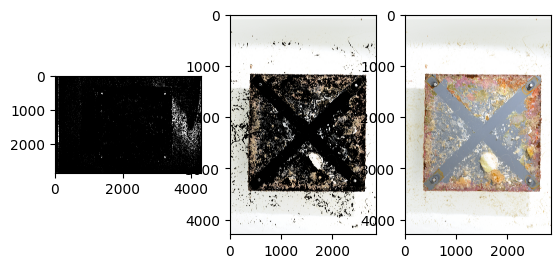

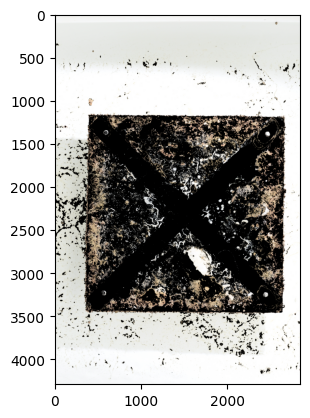

In [ ]:


#test display color range white

lo_square = np.full((10, 10, 3), whitesponge_light, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), whitesponge_dark, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(lo_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(do_square))
plt.show()

yellow_light = np.array([20, 100, 255])
yellow_dark = np.array([10, 0, 150])

#test display color range yellow

lo_square = np.full((10, 10, 3), yellow_light, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), yellow_dark, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(lo_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(do_square))
plt.show()


img = cv.imread('/content/20_ARMS_JPEGS/PLATE_JAR-04_2015_A_062.JPG')
assert img is not None, "file could not be read, check with os.path.exists()"

img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# OpenCV reads images in BGR so image needs to be converted to RGB
img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)


white_mask = cv.inRange(img_hsv, whitesponge_dark, whitesponge_light)
yellow_mask = cv.inRange(img_hsv, yellow_dark, yellow_light)

whitesponge_mask = white_mask + yellow_mask

result_img = cv.bitwise_and(img_rgb, img_rgb, mask=whitesponge_mask)


plt.subplot(1,3,1)
plt.imshow(whitesponge_mask, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(result_img)
plt.subplot(1, 3, 3)
plt.imshow(img_rgb)
plt.show()

plt.plot()
plt.imshow(result_img)
plt.show()

Generate actual outputs to write to drive

In [ ]:
# for actual output files
for i, imgName in enumerate(filenames):
  img = cv.imread(PATH + imgName)
  assert img is not None, "file could not be read, check with os.path.exists()"

  # RGB version
  img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

  # OpenCV reads images in BGR so image needs to be converted to RGB
  img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

  white_mask = cv.inRange(img_hsv, whitesponge_dark, whitesponge_light)
  yellow_mask = cv.inRange(img_hsv, yellow_dark, yellow_light)

  whitesponge_mask = white_mask + yellow_mask

  result_img = cv.bitwise_and(img_rgb, img_rgb, mask=whitesponge_mask)

  # convert RGB back to BGR so output image looks normal
  result_img = cv.cvtColor(result_img, cv.COLOR_RGB2BGR)

  if not cv.imwrite(sharePath + 'Preprocessing/ColorSeg_White/ColorSeg_White_' + imgName, result_img):
    raise Exception("Could not write to drive")

### Color Segmentation Takeaways

To summarize what we learned from this Color Segmentation technique, this technique is great at isolating distinct ranges that stand out from the rest of the image like is the case with Orange Sponge and CCA.

However, due to there being so many other things in the same color range as White Sponge, there ends up being a lot of noise when this method is used with White Sponge.

That being said, the mask threshold values were guesstimated from the 3D graph in HSV space so perhaps with a more concrete way of determining the color ranges, this method could yield even better results.

# Conclusion

Ultimately, although there are many different ways to process these images, it remains hard to isolate the different elements that the marine biologists are interested in. From edge detection to color segmentation, a lot of noise remains in the image which interferes with these techniques and makes it hard to draw a concrete conclusion. However, it seems like while there isn't a one size fits all solution, certain techiniques are good at isolating specific elements so perhaps a combination of these techniques will yield good results.
